# GAN vs CWoLa for producing QCD multi-jet events



First of all the training samples are loaded. Following the CWoLa approach, the data with at least 2 b-tags has a different signal fraction as the sample with only 1 b-tag. The sample consist of up to 6 permutations after the cut flow was aplied. The cut flow is displayed in the following.

![title](img/cut_flow.png)

In [1]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [2]:
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
import os 
import time
import matplotlib.pyplot as plt

In [3]:
My_CMS_data_6_permutations_flattened_2_btag = np.load('E:/Master Thesis Analysis Chapter/Analysis Results/Input data for NN/' \
                                                      'CMS_Delta_Rbb_2_0_two_btag_flattened.npy')
My_CMS_data_6_permutations_flattened_1_btag = np.load('E:/Master Thesis Analysis Chapter/Analysis Results/Input data for NN/' \
                                                      'CMS_Delta_Rbb_2_0_one_btag_flattened.npy')
My_TTbar_data_6_permutations_flattened = np.load('E:/Master Thesis Analysis Chapter/TTbar MC 6 permutations/172_5 GeV/' \
                                                 'Input data for NN/TTbar_Delta_Rbb_2_0_flattened.npy')
My_QCD_data_6_permutations_flattened = np.load('E:/Master Thesis Analysis Chapter/QCD MC 6 permutations/Input data for NN/' \
                                               'QCD_Delta_Rbb_2_0_flattened.npy')

complete_feature_dictionary = {'top.recoB1.Pt': 0,
                               'top.recoB2.Pt': 1,
                               'top.recoW1Prod1.Pt': 2,
                               'top.recoW1Prod2.Pt': 3,
                               'top.recoW2Prod1.Pt': 4,
                               'top.recoW2Prod2.Pt': 5,
                               'Delta_Rbb': 6,
                               'jet.bTag_B1': 7,
                               'jet.bTag_B2': 8,
                               'jet.bTag_W1P1': 9,
                               'jet.bTag_W1P2': 10,
                               'jet.bTag_W2P1': 11,
                               'jet.bTag_W2P2': 12,
                               'top.recoW1.M': 13,
                               'top.recoW2.M': 14,
                               'top.fitTop1.M': 15,
                               'top.fitProb': 16,
                               'top.combinationType': 17,
                               'top.decayChannel': 18,
                               'jet.HT': 19,
                               'jet.jet[5].Pt': 20,
                               'n_bjets': 21,
                               'top.lumiblock': 22,
                               'top.run': 23,
                               'top.event': 24,
                               'weight.combinedWeight': 25,
                               'combinedWeight_and_trigger_efficiency_correction': 26}

training_feature_slice = [complete_feature_dictionary['top.recoB1.Pt'],
                          complete_feature_dictionary['top.recoB2.Pt'],
                          complete_feature_dictionary['top.recoW1Prod1.Pt'],
                          complete_feature_dictionary['top.recoW1Prod2.Pt'],
                          complete_feature_dictionary['top.recoW2Prod1.Pt'],
                          complete_feature_dictionary['top.recoW2Prod2.Pt'],
                          complete_feature_dictionary['top.recoW1.M'],
                          complete_feature_dictionary['top.recoW2.M'],
                          complete_feature_dictionary['top.fitTop1.M'],
                          complete_feature_dictionary['top.fitProb'],
                          complete_feature_dictionary['jet.HT']]



def normalize_on_ht(data_set, dictionary, feature_list):
    data_set_return = np.copy(data_set)
    for feature in feature_list:
        if feature != dictionary['top.fitProb'] and feature != dictionary['jet.HT']:
            data_set_return[:, feature] = data_set_return[:, feature] / data_set_return[:, dictionary['jet.HT']]
        if feature == dictionary['jet.HT']:
            data_set_return[:, feature] = data_set_return[:, feature] / 5000
    return data_set_return


My_CMS_data_6_permutations_flattened_1_btag = normalize_on_ht(My_CMS_data_6_permutations_flattened_1_btag, 
                                                              complete_feature_dictionary,
                                                              training_feature_slice)

My_CMS_data_6_permutations_flattened_2_btag = normalize_on_ht(My_CMS_data_6_permutations_flattened_2_btag, 
                                                              complete_feature_dictionary,
                                                              training_feature_slice)

My_TTbar_data_6_permutations_flattened = normalize_on_ht(My_TTbar_data_6_permutations_flattened, 
                                                         complete_feature_dictionary,
                                                         training_feature_slice)

My_QCD_data_6_permutations_flattened = normalize_on_ht(My_QCD_data_6_permutations_flattened, 
                                                       complete_feature_dictionary,
                                                       training_feature_slice)

In [4]:
def generator_model():
    model = Sequential()
    model.add(Dense(512, input_dim=SEED_SIZE))  
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(len(training_feature_slice), activation='tanh'))
    
    return model

In [5]:
def discriminator_model():
    model = Sequential()
    model.add(Dense(256, input_dim=len(training_feature_slice)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(2, activation='softmax'))
    
    return model

In [6]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
SEED_SIZE = 200
BATCH_SIZE = 32
EPOCHS = 50
BUFFER_SIZE = 10000
SAVING_SEED_VECTOR = 100

generator = generator_model()
noise = np.random.normal(0, 1, (1, SEED_SIZE))

# generated_event = generator(noise, training=False)
discriminator = discriminator_model()

# decision = discriminator(generated_event)


generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.99, beta_2=0.999, amsgrad=False)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.99, beta_2=0.999, amsgrad=False)

In [8]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(
#     My_CMS_data_6_permutations_flattened_2_btag[:, training_feature_slice]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset = tf.data.Dataset.from_tensor_slices(
    My_TTbar_data_6_permutations_flattened[:, training_feature_slice]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [9]:
# @tf.function --> causes the function to be "compiled".
@tf.function
def train_step(events):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_events = generator(seed, training=True)

        real_output = discriminator(events, training=True)
        fake_output = discriminator(generated_events, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(\
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
           gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
    return gen_loss, disc_loss

In [10]:
def train(dataset, epochs):
    start = time.time()
    fixed_seed = np.random.normal(0, 1, (SAVING_SEED_VECTOR, SEED_SIZE))

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for event_batch in dataset:
            t = train_step(event_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss}, disc loss={d_loss}, {hms_string(epoch_elapsed)}')

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

In [11]:
train(train_dataset, EPOCHS)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, gen loss=0.6933640837669373, disc loss=1.386722445487976, 0:01:54.69
Epoch 2, gen loss=0.693290114402771, disc loss=1.386580228805542, 0:01:50.92
Epoch 3, gen loss=0.693290114402771, disc loss=1.386580228805542, 0:01:49.19
Epoch 4, gen loss=0.693290114402771, disc loss=1.386580228805542, 0:01:49.68
Epoch 5, gen loss=0.693290114402771, disc loss=1.386580228805542, 0:01:47.82
Epoch 6, gen loss=0.693290114402771, disc loss=1.386580228805542, 0:01:49.30
Epoch 7, gen loss=0.693290114402771, disc los

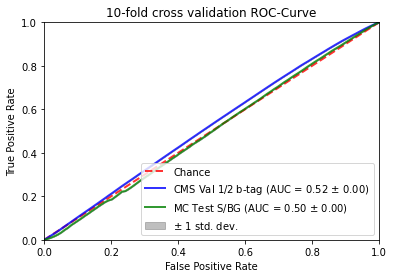

In [12]:
from sklearn.metrics import roc_curve, auc

import os
import matplotlib.pyplot as plt

# Part 1: CMS one vs. two btag
# Part 2: MC Simulation TTbar vs. QCD

# normalize input data to HT value, so all features have values in [0, 1]
x_cms_2_btag = My_CMS_data_6_permutations_flattened_2_btag
x_cms_1_btag = My_CMS_data_6_permutations_flattened_1_btag
x_ttbar = My_TTbar_data_6_permutations_flattened
x_qcd = My_QCD_data_6_permutations_flattened

# Concatenate for ROC-Classification
X_tr = np.concatenate([x_cms_2_btag, x_cms_1_btag])
y_tr = np.concatenate([np.ones(len(x_cms_2_btag)), np.zeros(len(x_cms_1_btag))])

X_evaluate = np.concatenate([x_ttbar, x_qcd])
y_evaluate = np.concatenate([np.ones(len(x_ttbar)), np.zeros(len(x_qcd))])

lum_MC = 35.9

# define lists for tpr, fpr, auc
tprs = []
tprs_evaluate_on_MC = []
aucs = []
aucs_evaluate_on_MC = []
mean_fpr = np.linspace(0, 1, 100)
mean_fpr_evaluate_on_MC = np.linspace(0, 1, 100)

predictions = backend.get_value(discriminator(X_tr[:, training_feature_slice]))
fpr, tpr, thresholds = roc_curve(y_tr,
                                 predictions[:, 1],
                                 sample_weight=X_tr[:, complete_feature_dictionary[
                                'weight.combinedWeight']])
tprs.append(np.interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

predictions_evaluate_on_MC = backend.get_value(discriminator(X_evaluate[:, training_feature_slice]))
fpr_evaluate_on_MC, tpr_evaluate_on_MC, thresholds_evaluate_on_MC\
     = roc_curve(y_evaluate,
                 predictions_evaluate_on_MC[:, 1],
                 sample_weight=lum_MC * X_evaluate[:, complete_feature_dictionary[
                     'combinedWeight_and_trigger_efficiency_correction']])
tprs_evaluate_on_MC.append(np.interp(mean_fpr_evaluate_on_MC, fpr_evaluate_on_MC, tpr_evaluate_on_MC))
tprs_evaluate_on_MC[-1][0] = 0.0
roc_auc_val = auc(fpr_evaluate_on_MC, tpr_evaluate_on_MC)
aucs_evaluate_on_MC.append(roc_auc_val)

plt.figure(0)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


# Training data
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'CMS Val 1/2 b-tag (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.5,
                 label=r'$\pm$ 1 std. dev.')


# Evaluation data
mean_tpr_evaluate_on_MC = np.mean(tprs_evaluate_on_MC, axis=0)
mean_tpr_evaluate_on_MC[-1] = 1.0
mean_auc_val = auc(mean_fpr_evaluate_on_MC, mean_tpr_evaluate_on_MC)
std_auc_val = np.std(aucs_evaluate_on_MC)
plt.plot(mean_fpr_evaluate_on_MC, mean_tpr_evaluate_on_MC, color='g',
         label=r'MC Test S/BG (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),
         lw=2, alpha=.8)

std_tpr_val = np.std(tprs_evaluate_on_MC, axis=0)
tprs_upper_val = np.minimum(mean_tpr_evaluate_on_MC + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_evaluate_on_MC - std_tpr_val, 0)
plt.fill_between(mean_fpr_evaluate_on_MC, tprs_lower_val, tprs_upper_val, color='grey', alpha=.5,
                 label='')


plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10-fold cross validation ROC-Curve')
plt.legend(loc="lower right")
# plt.savefig('ROC_Curve')
plt.show()
